In [2]:
import sys
import pandas as pd
import numpy as np
import random
import requests
import json
import matplotlib.pyplot as plt
import time
from nltk.book import *
from nltk.corpus import stopwords
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
import random
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
sns.set_context('notebook')
import warnings
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


/usr/local/lib/python3.7/site-packages/botocore/awsrequest.py:624: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class HeadersDict(collections.MutableMapping):
/usr/local/lib/python3.7/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict
/usr/local/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
#### get all csv dataframes for trending
US_trending_df = pd.read_csv('youtube-new/USvideos.csv') #USA
CA_trending_df = pd.read_csv('youtube-new/CAvideos.csv') #CANADA
DE_trending_df = pd.read_csv('youtube-new/DEvideos.csv') #GERMANY
FR_trending_df = pd.read_csv('youtube-new/FRvideos.csv') #FRANCE
GB_trending_df = pd.read_csv('youtube-new/GBvideos.csv') #GREAT BRITAIN
IN_trending_df = pd.read_csv('youtube-new/INvideos.csv') #INDIA
JP_trending_df = pd.read_csv('youtube-new/JPvideos.csv', encoding='ISO-8859-1') #JAPAN
KR_trending_df = pd.read_csv('youtube-new/KRvideos.csv' , encoding='ISO-8859-1') #SOUTH KOREA
MX_trending_df = pd.read_csv('youtube-new/MXvideos.csv', encoding='ISO-8859-1') #MEXICO
RU_trending_df = pd.read_csv('youtube-new/RUvideos.csv', encoding='ISO-8859-1') #RUSSIA

list_of_all_trending_dfs = [US_trending_df, CA_trending_df, DE_trending_df, FR_trending_df, GB_trending_df, IN_trending_df,
                           JP_trending_df, KR_trending_df, MX_trending_df, RU_trending_df]
full_trending_df = pd.concat(list_of_all_trending_dfs)

In [4]:
## run these to get the non trending datasets generated from the youtube api
import pandas as pd
not_trending_us_df = pd.read_csv('not_trending_us_df.csv')
not_trending_ca_df = pd.read_csv('not_trending_ca_df.csv')
not_trending_de_df = pd.read_csv('not_trending_de_df.csv')
not_trending_fr_df = pd.read_csv('not_trending_fr_df.csv')
not_trending_gb_df = pd.read_csv('not_trending_gb_df.csv')
not_trending_in_df = pd.read_csv('not_trending_in_df.csv')
not_trending_jp_df = pd.read_csv('not_trending_jp_df.csv')
not_trending_kr_df = pd.read_csv('not_trending_kr_df.csv')
not_trending_mx_df = pd.read_csv('not_trending_mx_df.csv')
not_trending_ru_df = pd.read_csv('not_trending_ru_df.csv')

In [162]:
### do not run this unless you have about 1 hour and 10 Youtube API keys!!!
f = open("apiKey", "r")
key = f.read()
## for each videoId, find a related video
def do_search_youtube_request(videoId):
    url = "https://www.googleapis.com/youtube/v3/search?part=snippet&maxResults=50&order=relevance&relatedToVideoId={}&type=video&videoDefinition=any&key={}".format(videoId, key)
    r = requests.get(url)
    return r

## given a set of videoIds, find insights (statistics, tags, etc)
def find_video_insights(videoIds):
    print(videoIds)
    url = 'https://www.googleapis.com/youtube/v3/videos?part=snippet%2CcontentDetails%2Cstatistics&id={}&key={}'.format(videoIds, key)
    r = requests.get(url)
    return r

## call this with 1 country at a time 
def process_youtube_requests(videoIds):
    df = pd.DataFrame(columns=['video_id', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 
                               'views', 'likes', 'dislikes', 'comment_count', 'description'])
    relatedVideoIds = []
    for videoId in videoIds:
        try: 
            response = do_search_youtube_request(videoId)
            time.sleep(2)
            if (response.status_code == 200):
                r1 = response.json()
                relatedVideoIdItems = r1['items']
                for id in relatedVideoIdItems:
                    relatedVideoId = id['id']['videoId']
                    relatedVideoIds.append(str(relatedVideoId))
            else:
                print(response.status_code)
        except:
            print ("Something went wrong here! 2")
    random.shuffle(relatedVideoIds)
    videoIdsForInsights = []
    for i in range(0, len(relatedVideoIds), 50):
        videoIdsForInsights.append(relatedVideoIds[i:i + n])
    for videoIdList in videoIdsForInsights:
        videoIdsStr = '%2C'.join([str(elem) for elem in videoIdList])
        r2 = find_video_insights(videoIdsStr)
        time.sleep(2)
        if (r2.status_code == 200):
            r = r2.json()
            i = 0
            while (i < len(videoIdList)):
                try:
                    id = videoIdList[i]
                    title = (r['items'][i]['snippet']['title'])
                    channel_title = (r['items'][i]['snippet']['channelTitle'])
                    category_id = (r['items'][i]['snippet']['categoryId'])
                    publish_time = (r['items'][i]['snippet']['publishedAt'])
                    tags = '|'.join((r['items'][i]['snippet']['tags']))
                    views = (r['items'][i]['statistics']['viewCount'])
                    likes = (r['items'][i]['statistics']['likeCount'])
                    dislikes = (r['items'][i]['statistics']['dislikeCount'])
                    comment_count = (r['items'][i]['statistics']['commentCount'])
                    description = (r['items'][i]['snippet']['description'])
                    data = {'video_id': id, 'title': title, 'channel_title': channel_title, 'category_id' : category_id,
                           'publish_time' : publish_time, 'tags' : tags, 'views' : views, 'likes' : likes, 'dislikes' : dislikes,
                           'comment_count' : comment_count, 'description' : description}
                    df = df.append(data, ignore_index = True)
                except:
                    print("Something went wrong! 3")
                i = i + 1
        else:
            print("Something went wrong! 4")
            print (r2.status_code)
            print(r2.text)
    return df
        

In [149]:
### do not run this unless you have about 1 hour and 10 Youtube API keys!!!

n = 50
US_trending_videoIds = US_trending_df.sample(n)['video_id'].tolist()
CA_trending_videoIds = CA_trending_df.sample(n)['video_id'].tolist()
DE_trending_videoIds = DE_trending_df.sample(n)['video_id'].tolist()
FR_trending_videoIds = FR_trending_df.sample(n)['video_id'].tolist()
GB_trending_videoIds = GB_trending_df.sample(n)['video_id'].tolist()
IN_trending_videoIds = IN_trending_df.sample(n)['video_id'].tolist()
JP_trending_videoIds = JP_trending_df.sample(n)['video_id'].tolist()
KR_trending_videoIds = KR_trending_df.sample(n)['video_id'].tolist()
MX_trending_videoIds = MX_trending_df.sample(n)['video_id'].tolist()
RU_trending_videoIds = RU_trending_df.sample(n)['video_id'].tolist()

In [ ]:
### do not run this unless you have about 1 hour and 10 Youtube API keys!!!

## do following requests separately with a new API Key
not_trending_us_df = process_youtube_requests(US_trending_videoIds)
not_trending_ca_df = process_youtube_requests(CA_trending_videoIds)
not_trending_de_df = process_youtube_requests(DE_trending_videoIds)
not_trending_fr_df = process_youtube_requests(FR_trending_videoIds)
not_trending_gb_df = process_youtube_requests(GB_trending_videoIds)
not_trending_in_df = process_youtube_requests(IN_trending_videoIds)
not_trending_jp_df = process_youtube_requests(JP_trending_videoIds)
not_trending_kr_df = process_youtube_requests(KR_trending_videoIds)
not_trending_mx_df = process_youtube_requests(MX_trending_videoIds)
not_trending_ru_df = process_youtube_requests(RU_trending_videoIds)

In [5]:
list_of_all_nontrending_dfs = [not_trending_us_df, not_trending_ca_df, not_trending_de_df, 
                              not_trending_fr_df, not_trending_gb_df, not_trending_in_df, not_trending_jp_df,
                              not_trending_kr_df, not_trending_mx_df, not_trending_ru_df]


full_nontrending_df = pd.concat(list_of_all_nontrending_dfs)
allDfsList = list_of_all_trending_dfs + list_of_all_nontrending_dfs + [full_trending_df] + [full_nontrending_df]
allDfsDf = pd.concat(allDfsList)
allDfsList.append(allDfsDf)

In [6]:
def insert_category_field(df):
    # add a category column using the category id from the json file
    id_to_category = {}
    with open("youtube-new/US_category_id.json", 'r') as f: # the other category json files have missing category ids. We decided to just use the US file since it contained all of them and since they are standard internationally. 
        data = json.load(f)
        for category in data['items']:
            id_to_category[category['id']] = category['snippet']['title']
        categories = []
        for id in list(df['category_id']):
            categories.append(id_to_category[str(id)])
        df.insert(4, 'category', categories)

In [7]:
## insert new category field into dataframes
for df in allDfsList:
    insert_category_field(df)

In [8]:
for df in list_of_all_nontrending_dfs:
    df['video_id'] = df['video_id'].astype(str) 
    df['title'] = df['title'].astype(str)
    df['channel_title'] = df['channel_title'].astype(str)
    df['category_id'] = df['category_id'].astype(int)
    df['category'] = df['category'].astype(str)
    df['tags'] = df['tags'].astype(str)
    df['views'] = df['views'].astype(int)
    df['likes'] = df['likes'].astype(int)
    df['dislikes'] = df['dislikes'].astype(int)
    df['comment_count'] = df['comment_count'].astype(int)
    df['description'] = df['description'].astype(str)

In [9]:
def find_stats(df):
    views = df['views']
    likes = df['likes']
    dislikes = df['dislikes']
    comment_count = df['comment_count']
    tags = list(df['tags'])
    tagsList = []
    for t in tags: 
        tagsList.append(len(t.split('|')))
    viewsStats = [views.sum(), views.sum() / len(views), views.min(), views.max()]
    likesStats = [likes.sum(), likes.sum() / len(likes), likes.min(), likes.max()]
    dislikesStats = [dislikes.sum(), dislikes.sum() / len(dislikes), dislikes.min(), dislikes.max()]
    commentsStats = [comment_count.sum(), comment_count.sum() / len(comment_count), comment_count.min(), comment_count.max()]
    tagsStats = [sum(tagsList), sum(tagsList) / len(tagsList), min(tagsList), max(tagsList)]
    statsDf = pd.DataFrame({'views': viewsStats, 'likes': likesStats, 'dislikes': dislikesStats, 'comment_count': commentsStats, 'tags': tagsStats}, index = ['count', 'mean', 'min', 'max']) 
    return statsDf

In [10]:
## output is a map containing all the numeric data for each df
describes = []
for df in allDfsList:
    describes.append(find_stats(df))
describesKeys = ['US_trending_df', 'CA_trending_df', 'DE_trending_df', 'FR_trending_df', 'GB_trending_df',
                'IN_trending_df', 'JP_trending_df', 'KR_trending_df', 'MX_trending_df', 'RU_trending_df',
                 'not_trending_us_df', 'not_trending_ca_df', 'not_trending_de_df', 'not_trending_fr_df',
                'not_trending_gb_df', 'not_trending_in_df', 'not_trending_jp_df', 'not_trending_kr_df',
                 'not_trending_mx_df', 'not_trending_ru_df',
                'full_trending_df', 'full_nontrending_df', 'allDfsDf']
describeMap = dict(zip(describesKeys, describes))

In [10]:
describeMap
## find stats on a specific country: describeMap['US_trending_df']
### lets visualize this since this is all our numeric data!! 

{'US_trending_df':               views         likes      dislikes  comment_count           tags
 count  9.667177e+10  3.041147e+09  1.519782e+08   3.458882e+08  808183.000000
 mean   2.360785e+06  7.426670e+04  3.711401e+03   8.446804e+03      19.736331
 min    5.490000e+02  0.000000e+00  0.000000e+00   0.000000e+00       1.000000
 max    2.252119e+08  5.613827e+06  1.674420e+06   1.361580e+06      69.000000,
 'CA_trending_df':               views         likes      dislikes  comment_count           tags
 count  4.689198e+10  1.618180e+09  8.213792e+07   2.061618e+08  800372.000000
 mean   1.147036e+06  3.958269e+04  2.009195e+03   5.042975e+03      19.578093
 min    7.330000e+02  0.000000e+00  0.000000e+00   0.000000e+00       1.000000
 max    1.378431e+08  5.053338e+06  1.602383e+06   1.114800e+06     124.000000,
 'DE_trending_df':               views         likes      dislikes  comment_count           tags
 count  2.464512e+10  8.933955e+08  5.705903e+07   1.137744e+08  733959.000

In [11]:
###get most common tags
def get_most_common_tags(country_df):
    tags = country_df['tags'].to_string(index=False, header=False)
    split_tags = [i.replace('"', '') for i in tags.split("|")]
    stop_words = stopwords.words('english')
    filtered_tags = [word for word in split_tags if word not in stop_words]
    fdist = FreqDist(split_tags)
    most_popular_tags = fdist.most_common(1000)
    return dict(most_popular_tags)

In [12]:
## a bunch of maps containing the most popular tags for each country that are both trending and not trending and their frequency
us_trending_most_common_tags = get_most_common_tags(US_trending_df)
ca_trending_most_common_tags = get_most_common_tags(CA_trending_df)
de_trending_most_common_tags = get_most_common_tags(DE_trending_df)
fr_trending_most_common_tags = get_most_common_tags(FR_trending_df)
gb_trending_most_common_tags = get_most_common_tags(GB_trending_df)
in_trending_most_common_tags = get_most_common_tags(IN_trending_df)
jp_trending_most_common_tags = get_most_common_tags(JP_trending_df)
kr_trending_most_common_tags = get_most_common_tags(KR_trending_df)
mx_trending_most_common_tags = get_most_common_tags(MX_trending_df)
ru_trending_most_common_tags = get_most_common_tags(RU_trending_df)

us_nontrending_most_common_tags = get_most_common_tags(not_trending_us_df)
ca_nontrending_most_common_tags = get_most_common_tags(not_trending_ca_df)
de_nontrending_most_common_tags = get_most_common_tags(not_trending_de_df)
fr_nontrending_most_common_tags = get_most_common_tags(not_trending_fr_df)
gb_nontrending_most_common_tags = get_most_common_tags(not_trending_gb_df)
in_nontrending_most_common_tags = get_most_common_tags(not_trending_in_df)
jp_nontrending_most_common_tags = get_most_common_tags(not_trending_jp_df)
kr_nontrending_most_common_tags = get_most_common_tags(not_trending_kr_df)
mx_nontrending_most_common_tags = get_most_common_tags(not_trending_mx_df)
ru_nontrending_most_common_tags = get_most_common_tags(not_trending_ru_df)
### do visualization on these most common tags!!!

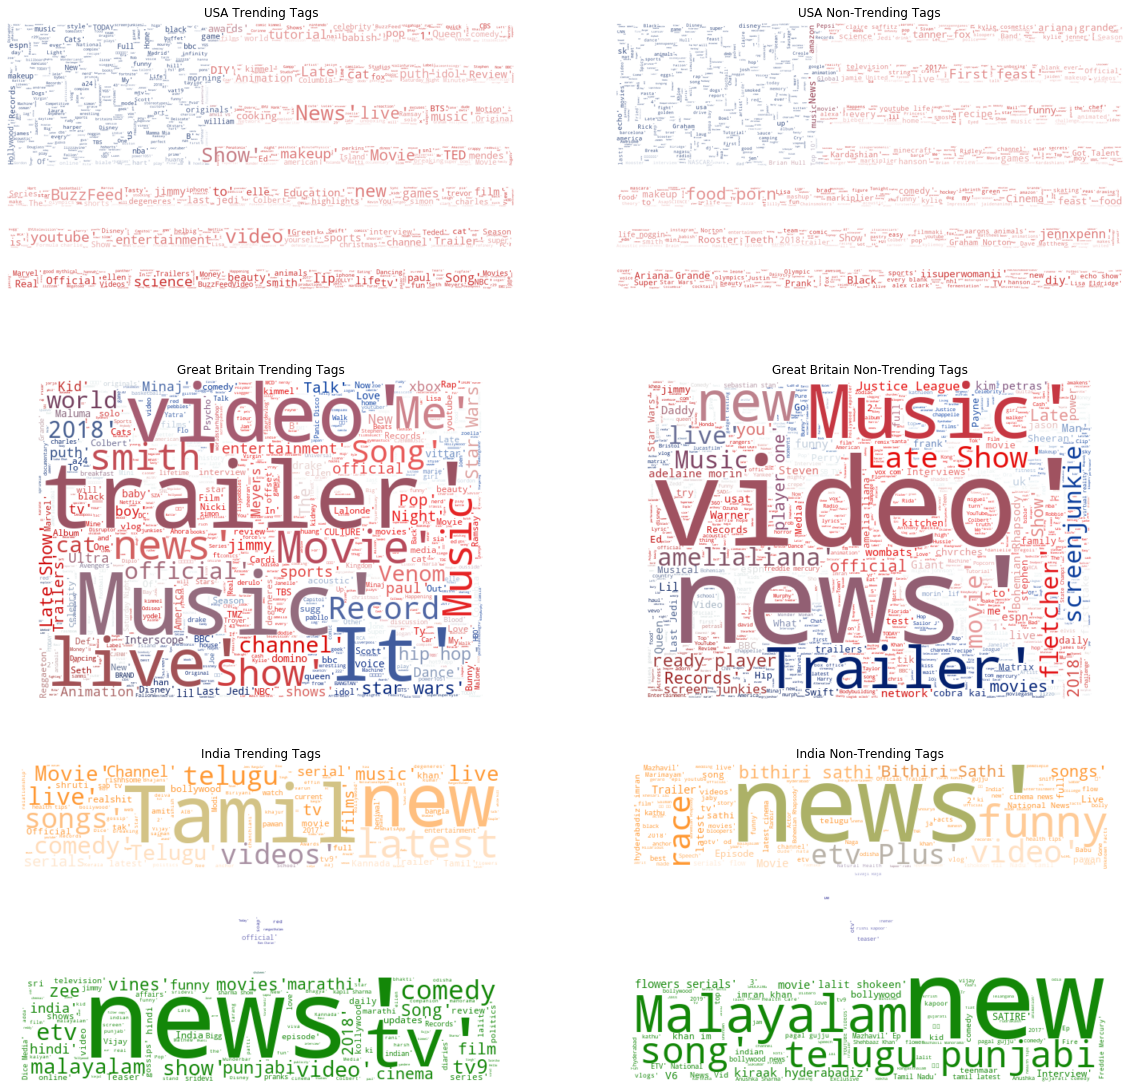

<Figure size 1440x1440 with 0 Axes>

In [65]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

links = ['https://cdn.pixabay.com/photo/2017/03/14/21/00/american-flag-2144392_960_720.png', 
        'https://i.pinimg.com/originals/93/85/dd/9385dde0f8cf96e0c60e5e659036b303.jpg',
        'https://cdn.britannica.com/97/1597-004-7C2918C6/Flag-India.jpg']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
mask_USA = np.array(Image.open(requests.get(links[0], stream=True).raw))
mask_GB = np.array(Image.open(requests.get(links[1], stream=True).raw))
mask_IN = np.array(Image.open(requests.get(links[2], stream=True).raw))
image_colors_usa = ImageColorGenerator(mask_USA)
image_colors_gb = ImageColorGenerator(mask_GB)
image_colors_in = ImageColorGenerator(mask_IN)
wordcloud_usa_trending = WordCloud(width=1000, height=1000, mask=mask_USA, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(us_trending_most_common_tags.keys())))
wordcloud_gb_trending = WordCloud(width=1000, height=1000, mask=mask_GB, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(gb_trending_most_common_tags.keys())))
wordcloud_in_trending = WordCloud(width=1000, height=1000, mask=mask_IN, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(in_trending_most_common_tags.keys())))


wordcloud_usa_nontrending = WordCloud(width=1000, height=1000, mask=mask_USA, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(us_nontrending_most_common_tags.keys())))
wordcloud_gb_nontrending = WordCloud(width=1000, height=1000, mask=mask_GB, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(gb_nontrending_most_common_tags.keys())))
wordcloud_in_nontrending = WordCloud(width=1000, height=1000, mask=mask_IN, background_color="white", max_words=1000, max_font_size=1000).generate(str(list(in_nontrending_most_common_tags.keys())))


plt.figure(figsize=(20,20), facecolor='k')

axes[0, 0].imshow(wordcloud_usa_trending.recolor(color_func=image_colors_usa), interpolation="bilinear")
axes[0, 0].set_title("USA Trending Tags")
axes[0, 0].axis("off")

axes[1, 0].imshow(wordcloud_gb_trending.recolor(color_func=image_colors_gb), interpolation="bilinear")
axes[1, 0].set_title("Great Britain Trending Tags")
axes[1, 0].axis("off")


axes[2, 0].imshow(wordcloud_in_trending.recolor(color_func=image_colors_in), interpolation="bilinear")
axes[2, 0].set_title("India Trending Tags")
axes[2, 0].axis("off")

axes[0, 1].imshow(wordcloud_usa_nontrending.recolor(color_func=image_colors_usa), interpolation="bilinear")
axes[0, 1].set_title("USA Non-Trending Tags")
axes[0, 1].axis("off")


axes[1, 1].imshow(wordcloud_gb_nontrending.recolor(color_func=image_colors_gb), interpolation="bilinear")
axes[1, 1].set_title("Great Britain Non-Trending Tags")
axes[1, 1].axis("off")




axes[2, 1].imshow(wordcloud_in_nontrending.recolor(color_func=image_colors_in), interpolation="bilinear")
axes[2, 1].set_title("India Non-Trending Tags")
axes[2, 1].axis("off")



plt.tight_layout(pad=0)
plt.show()

In [52]:
## do sentiment analysis on each of the tags
## return classifications on each of the tags in both trending and non-trending per country
positive_words_df = pd.read_fwf('positivewords.txt')
negative_words_df = pd.read_fwf('negativewords.txt')

def extract_features(words):
    return dict([(word, True) for word in words.split()])

def build_sentiment_analysis_model():
    positive_words = positive_words_df['positivewords'].values.tolist()
    negative_words = negative_words_df['negativewords'].values.tolist()
    pos_feats = [(extract_features(f), 'positive') for f in positive_words ]
    neg_feats = [(extract_features(f), 'negative') for f in negative_words ]
    dataset = pos_feats + neg_feats
    random.shuffle(dataset)
    cutoff = int(0.80 * len(dataset))
    train_data = dataset[:cutoff]
    test_data = dataset[cutoff:]

    classifier = NaiveBayesClassifier.train(train_data)
    print("Accuracy is:", classify.accuracy(classifier, test_data))
    # print(classifier.show_most_informative_features(10))
    return classifier

def execute_model(tags):
    classifications = {}
    classifier = build_sentiment_analysis_model()
    # classifier.show_most_informative_features(5)
    for tag in tags:
        classified = classifier.classify(extract_features(tag))
        classifications[tag] = classified
    return classifications

In [53]:
classifications_us_trending = execute_model(list(us_trending_most_common_tags.keys()))
classifications_ca_trending = execute_model(list(ca_trending_most_common_tags.keys()))
classifications_de_trending = execute_model(list(de_trending_most_common_tags.keys()))
classifications_fr_trending = execute_model(list(fr_trending_most_common_tags.keys()))
classifications_gb_trending = execute_model(list(gb_trending_most_common_tags.keys()))
classifications_in_trending = execute_model(list(in_trending_most_common_tags.keys()))
classifications_jp_trending = execute_model(list(jp_trending_most_common_tags.keys()))
classifications_kr_trending = execute_model(list(kr_trending_most_common_tags.keys()))
classifications_mx_trending = execute_model(list(mx_trending_most_common_tags.keys()))
classifications_ru_trending = execute_model(list(ru_trending_most_common_tags.keys()))

classifications_us_nontrending = execute_model(list(us_nontrending_most_common_tags.keys()))
classifications_ca_nontrending = execute_model(list(ca_nontrending_most_common_tags.keys()))
classifications_de_nontrending = execute_model(list(de_nontrending_most_common_tags.keys()))
classifications_fr_nontrending = execute_model(list(fr_nontrending_most_common_tags.keys()))
classifications_gb_nontrending = execute_model(list(gb_nontrending_most_common_tags.keys()))
classifications_in_nontrending = execute_model(list(in_nontrending_most_common_tags.keys()))
classifications_jp_nontrending = execute_model(list(jp_nontrending_most_common_tags.keys()))
classifications_kr_nontrending = execute_model(list(kr_nontrending_most_common_tags.keys()))
classifications_mx_nontrending = execute_model(list(mx_nontrending_most_common_tags.keys()))
classifications_ru_nontrending = execute_model(list(ru_nontrending_most_common_tags.keys()))

Accuracy is: 0.6501994476833385
Accuracy is: 0.6409941699907947
Accuracy is: 0.6265725682724762
Accuracy is: 0.6339367904265112
Accuracy is: 0.6354710033752685
Accuracy is: 0.6299478367597422
Accuracy is: 0.6394599570420374
Accuracy is: 0.6434489107088064
Accuracy is: 0.6385394292727831
Accuracy is: 0.6440625958883093
Accuracy is: 0.6354710033752685
Accuracy is: 0.645903651426818
Accuracy is: 0.6419146977600491
Accuracy is: 0.6449831236575637
Accuracy is: 0.6342436330162626
Accuracy is: 0.6505062902730899
Accuracy is: 0.6293341515802393
Accuracy is: 0.6400736422215404
Accuracy is: 0.6366983737342743
Accuracy is: 0.6379257440932802


In [56]:
def get_sentiment_stats(classification, country):
    sentiments = list(classification.values())
    sentiments_df = pd.DataFrame(sentiments, columns=['Sentiment'])
    negatives = len(sentiments_df[sentiments_df['Sentiment'] =='negative'])
    positives = len(sentiments_df[sentiments_df['Sentiment'] =='positive'])
    total_len = len(sentiments_df)
    percentage_of_negative = negatives / total_len * 100
    percentage_of_positive = positives / total_len * 100
    ratio = positives/negatives
    ratioStr = "{} positive/negative ratio: {} -----> {}% positives of total , {}% negatives of total".format(country, ratio, percentage_of_positive, percentage_of_negative)
    print (ratioStr)
    return country, percentage_of_positive, percentage_of_negative

In [248]:
country_us_trending, us_trending_pos, us_trending_neg = get_sentiment_stats(classifications_us_trending, "USA_Trending")
country_ca_trending, ca_trending_pos, ca_trending_neg = get_sentiment_stats(classifications_ca_trending, "Canada_Trending")
country_de_trending, de_trending_pos, de_trending_neg = get_sentiment_stats(classifications_de_trending, "Denmark_Trending")
country_fr_trending, fr_trending_pos, fr_trending_neg = get_sentiment_stats(classifications_fr_trending, "France_Trending")
country_gb_trending, gb_trending_pos, gb_trending_neg = get_sentiment_stats(classifications_gb_trending, "GreatBritain_Trending")
country_in_trending, in_trending_pos, in_trending_neg = get_sentiment_stats(classifications_in_trending, "India_Trending")
country_jp_trending, jp_trending_pos, jp_trending_neg = get_sentiment_stats(classifications_jp_trending, "Japan_Trending")
country_kr_trending, kr_trending_pos, kr_trending_neg = get_sentiment_stats(classifications_kr_trending, "SouthKorea_Trending")
country_mx_trending, mx_trending_pos, mx_trending_neg = get_sentiment_stats(classifications_mx_trending, "Mexico_Trending")
country_ru_trending, ru_trending_pos, ru_trending_neg = get_sentiment_stats(classifications_ru_trending, "Russia_Trending")


country_us_nontrending, us_nontrending_pos, us_nontrending_neg = get_sentiment_stats(classifications_us_nontrending, "USA_NonTrending")
country_ca_nontrending, ca_nontrending_pos, ca_nontrending_neg = get_sentiment_stats(classifications_ca_nontrending, "Canada_NonTrending")
country_de_nontrending, de_nontrending_pos, de_nontrending_neg = get_sentiment_stats(classifications_de_nontrending, "Denmark_NonTrending")
country_fr_nontrending, fr_nontrending_pos, fr_nontrending_neg = get_sentiment_stats(classifications_fr_nontrending, "France_NonTrending")
country_gb_nontrending, gb_nontrending_pos, gb_nontrending_neg = get_sentiment_stats(classifications_gb_nontrending, "GreatBritain_NonTrending")
country_in_nontrending, in_nontrending_pos, in_nontrending_neg = get_sentiment_stats(classifications_in_nontrending, "India_NonTrending")
country_jp_nontrending, jp_nontrending_pos, jp_nontrending_neg = get_sentiment_stats(classifications_jp_nontrending, "Japan_NonTrending")
country_kr_nontrending, kr_nontrending_pos, kr_nontrending_neg = get_sentiment_stats(classifications_kr_nontrending, "SouthKorea_NonTrending")
country_mx_nontrending, mx_nontrending_pos, mx_nontrending_neg = get_sentiment_stats(classifications_mx_nontrending, "Mexico_NonTrending")
country_ru_nontrending, ru_nontrending_pos, ru_nontrending_neg = get_sentiment_stats(classifications_ru_nontrending, "Russia_NonTrending")

countries = [country_us_trending, country_ca_trending, country_de_trending, country_fr_trending, country_gb_trending,
            country_in_trending, country_jp_trending, country_kr_trending, country_mx_trending, country_ru_trending,
            country_us_nontrending, country_ca_nontrending, country_de_nontrending, country_fr_nontrending, 
            country_gb_nontrending, country_in_nontrending, country_jp_nontrending, country_kr_nontrending, 
            country_mx_nontrending, country_ru_nontrending]
positivePercenteages = [us_trending_pos, ca_trending_pos, de_trending_pos, fr_trending_pos, gb_trending_pos, in_trending_pos, jp_trending_pos,
            kr_trending_pos, mx_trending_pos, ru_trending_pos, us_nontrending_pos, ca_nontrending_pos, de_nontrending_pos, fr_nontrending_pos,
            gb_nontrending_pos, in_nontrending_pos, jp_nontrending_pos, kr_nontrending_pos, mx_nontrending_pos, ru_nontrending_pos]
negativePercentages = [us_trending_neg, ca_trending_neg, de_trending_neg, fr_trending_neg, gb_trending_neg, in_trending_neg, jp_trending_neg, 
                      kr_trending_neg, mx_trending_neg, ru_trending_neg, us_nontrending_neg, ca_nontrending_neg, de_nontrending_neg, 
                      fr_nontrending_neg, gb_nontrending_neg, in_nontrending_neg, jp_nontrending_neg, kr_nontrending_neg, mx_nontrending_neg,
                      ru_nontrending_neg]
posToNegRatios = [i / j for i, j in zip(positivePercenteages, negativePercentages)] 
data_dict = {"Country" : countries, "Positives": positivePercenteages, "Negatives": negativePercentages, "PositiveNegativeRatio": posToNegRatios}
data = pd.DataFrame(data_dict, columns = ['Country', 'Positives' , 'Negatives', 'PositiveNegativeRatio'])

data
## visualize these!!! 

USA_Trending positive/negative ratio: 0.19617224880382775 -----> 16.400000000000002% positives of total , 83.6% negatives of total
Canada_Trending positive/negative ratio: 0.2755102040816326 -----> 21.6% positives of total , 78.4% negatives of total
Denmark_Trending positive/negative ratio: 0.19904076738609114 -----> 16.6% positives of total , 83.39999999999999% negatives of total
France_Trending positive/negative ratio: 0.1273957158962796 -----> 11.3% positives of total , 88.7% negatives of total
GreatBritain_Trending positive/negative ratio: 0.2285012285012285 -----> 18.6% positives of total , 81.39999999999999% negatives of total
India_Trending positive/negative ratio: 0.37362637362637363 -----> 27.200000000000003% positives of total , 72.8% negatives of total
Japan_Trending positive/negative ratio: 0.09529025191675794 -----> 8.7% positives of total , 91.3% negatives of total
SouthKorea_Trending positive/negative ratio: 0.08225108225108226 -----> 7.6% positives of total , 92.4% nega

,Country,Positives,Negatives,PositiveNegativeRatio
0,USA_Trending,16.4,83.6,0.196172
1,Canada_Trending,21.6,78.4,0.275510
2,Denmark_Trending,16.6,83.4,0.199041
3,France_Trending,11.3,88.7,0.127396
4,GreatBritain_Trending,18.6,81.4,0.228501
5,India_Trending,27.2,72.8,0.373626
6,Japan_Trending,8.7,91.3,0.095290
7,SouthKorea_Trending,7.6,92.4,0.082251
8,Mexico_Trending,14.0,86.0,0.162791
9,Russia_Trending,12.0,88.0,0.136364


In [307]:
## import pandas as pd
import bokeh.plotting as bp
from bokeh.models import HoverTool, ColorBar, NumeralTickFormatter, LinearColorMapper, LassoSelectTool, ResetTool, PanTool, BoxSelectTool, TapTool, PolySelectTool
from bokeh.palettes import plasma
from bokeh.plotting import figure
from bokeh.transform import transform
import bokeh.io
import bokeh.plotting as bpl
import bokeh.models as bmo
from bokeh.palettes import d3
from bokeh.transform import linear_cmap
from bokeh.models import SingleIntervalTicker, LinearAxis
from bokeh.layouts import gridplot

bokeh.io.reset_output()
bokeh.io.output_notebook()
mySource = bp.ColumnDataSource(data)
#Use the field name of the column source
mapper = linear_cmap(field_name='Positives', palette="Spectral6" ,low=max(list(data['Positives']) + list(data['Negatives'])) ,high=min(list(data['Positives']) + list(data['Negatives'])))

hover = HoverTool()
hover.tooltips = [
    ("(x,y)", "($x, $y)"),
    ("Country", "@Country"),
    ("Ratio" , "@PositiveNegativeRatio")
]
myPlot = bp.figure(
               title = 'Positives vs. Negatives',
               plot_height=500,
               plot_width=500, 
    tools = [BoxSelectTool(), LassoSelectTool(), ResetTool(), hover, TapTool(), PolySelectTool()], 
    background_fill_color = "black",
    x_axis_label = 'Positives', y_axis_label = 'Negatives',
x_range=(0, 100), y_range=(0, 100))
myPlot.title.text_font_size = '20pt'
myPlot.xaxis.axis_label_text_font_size = "20pt"
myPlot.yaxis.axis_label_text_font_size = "20pt"
myPlot.xaxis.ticker = SingleIntervalTicker(interval=5)
myPlot.yaxis.ticker = SingleIntervalTicker(interval=5)
myPlot.circle("Positives",
          "Negatives",
              line_color=mapper,color=mapper, fill_alpha=1, 
          source=mySource,
          size = 12,
             selection_color='deepskyblue',
           nonselection_color='lightgray',
             hover_fill_color='yellow', hover_alpha=2.0)
color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))

myPlot.add_layout(color_bar, 'right')


from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.palettes import Category20
from bokeh.models import Legend

bokeh.io.reset_output()
bokeh.io.output_notebook()


countries = list(data['Country'])
hover = HoverTool(
    tooltips=[
        ("Ratio", "@top")
    ]
)

colors = ['red', 'red', 'red', 'red',
          'red', 'red', 'red', 'red',
          'red', 'red', 'green', 'green', 'green', 'green',
          'green', 'green', 'green', 'green',
          'green', 'green']


p = figure(x_range=countries, plot_height=500, title="Sentiment Analysis Ratios", width = 500,  background_fill_color = "black")
legends = ['Trending', 'Not Trending']
v = p.vbar(x=countries, top=list(data['PositiveNegativeRatio']), width=0.5, color=colors)
v1 = p.vbar(x=countries, top=list(data['PositiveNegativeRatio']), width=0.5, color='green')
p.add_layout(Legend(items=[
        ("Trending"   , [v]),
        ("NonTrending" , [v1]),
    ]))
v1.visible = False

p.add_tools(hover)
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.major_label_orientation = -1.5
p.xaxis.axis_label = "Countries"
p.yaxis.axis_label = "Ratio of Positive:Negative"
p.xgrid.grid_line_color = None

p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"



# Bokeh Library
from bokeh.io import output_file
from bokeh.models.widgets import Tabs, Panel


# Increase the plot widths
myPlot.plot_width = p.plot_width = 1000

# Create two panels, one for each conference
myPlotPanel = Panel(child=myPlot, title='Positives vs. Negatives')
pPanel = Panel(child=p, title='Sentiment Analysis Ratios')

# Assign the panels to Tabs
tabs = Tabs(tabs=[pPanel, myPlotPanel])

# Show the tabbed layout
show(tabs)

Loading BokehJS ...

Loading BokehJS ...

In [214]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

def prepare_text_for_lda(text):
    tokens = tokenize(str(text))
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

[nltk_data] Downloading package wordnet to /Users/aravind/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aravind/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [215]:
import random
from gensim import corpora
import gensim
import pickle
def do_LDA(lda_input):
    text_data = []
    for line in lda_input:
        tokens = prepare_text_for_lda(line)
        if random.random() > .99:
            text_data.append(tokens)
    topics, corpus, dictionary = execute_LDA(text_data)
    return topics, corpus, dictionary
    
def execute_LDA(text_data):
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words=10)
    return topics, corpus, dictionary

import re
def clean_lda_input(input):
    l = []
    for a in input:
        text = re.sub(r"http\S+", "", str(a))
        l.append(text)
    return l

In [216]:
def visualize_LDA(start, corpus, dictionary):
    if (start == True):
        lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
        lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
        return lda_display

In [220]:
full_trending_lda_input = list(get_most_common_tags(full_trending_df).keys()) + list (full_trending_df.sample(16901)['description'])
topics_Full_Trending, corpus, dictionary = do_LDA(full_trending_lda_input)
lda_display = visualize_LDA(True, corpus, dictionary)
pyLDAvis.display(lda_display)

In [221]:
for t in topics_Full_Trending:
    print(t)

(0, '0.012*"video" + 0.007*"youtube" + 0.005*"weight" + 0.005*"channel" + 0.004*"subscribe" + 0.003*"SCREEN_NAME" + 0.003*"street" + 0.003*"wire" + 0.003*"index" + 0.003*"candy"')
(1, '0.005*"video" + 0.005*"channel" + 0.004*"twitter" + 0.004*"facebook" + 0.004*"instagram" + 0.004*"mikro" + 0.003*"track" + 0.003*"links" + 0.003*"coaster" + 0.003*"roller"')
(2, '0.004*"award" + 0.004*"facebook" + 0.004*"ð³ñ\x80ð" + 0.004*"ð²ð¸ð´ðµð¾" + 0.004*"ñ\x81ñ\x82ñ\x80ð" + 0.004*"ð¿ñ\x80ð" + 0.004*"produits" + 0.003*"comment" + 0.003*"ـلوونة" + 0.003*"وليفـ"')
(3, '0.011*"rainbow" + 0.010*"siege" + 0.006*"jimmy" + 0.006*"tonight" + 0.004*"fallon" + 0.003*"video" + 0.003*"music" + 0.003*"star" + 0.003*"einen" + 0.003*"latest"')
(4, '0.013*"official" + 0.012*"video" + 0.009*"music" + 0.009*"audio)\\ndrake" + 0.008*"youtube" + 0.004*"please" + 0.003*"tonight" + 0.003*"twitter" + 0.003*"ð½ð³ð" + 0.003*"follow"')
(5, '0.008*"facebook" + 0.007*"video" + 0.006*"koova" + 0.005*"twitter" + 0.004*"youtube" 

In [222]:
full_nontrending_lda_input = list(get_most_common_tags(full_nontrending_df).keys()) + list (full_nontrending_df['description'])
topics_Full_Nontrending, corpus, dictionary = do_LDA(full_nontrending_lda_input)
lda_display = visualize_LDA(True, corpus, dictionary)
pyLDAvis.display(lda_display)

In [223]:
for t in topics_Full_Nontrending:
    print(t)

(0, '0.019*"music" + 0.017*"warner" + 0.012*"license" + 0.011*"chappell" + 0.011*"production" + 0.007*"pavilion" + 0.006*"bros." + 0.006*"amphitheatre" + 0.003*"video" + 0.003*"league"')
(1, '0.009*"follow" + 0.009*"msnbc" + 0.008*"facebook" + 0.008*"viuda" + 0.008*"negra" + 0.007*"jimmy" + 0.006*"tonight" + 0.005*"video" + 0.005*"available" + 0.005*"house"')
(2, '0.056*"gujarati" + 0.036*"video" + 0.028*"comedy" + 0.010*"joke" + 0.010*"funny" + 0.007*"download" + 0.007*"queen" + 0.006*"gujju" + 0.006*"kuzgun" + 0.005*"película"')
(3, '0.006*"SCREEN_NAME" + 0.006*"sport" + 0.004*"facebook" + 0.004*"smosh" + 0.004*"twitter" + 0.004*"extraits" + 0.004*"ольга" + 0.003*"music" + 0.003*"channel" + 0.003*"subscribe"')
(4, '0.021*"video" + 0.012*"music" + 0.010*"facebook" + 0.008*"twitter" + 0.008*"shake" + 0.007*"instagram" + 0.007*"channel" + 0.007*"alright" + 0.005*"satisfy" + 0.005*"subscribe"')
(5, '0.009*"subscriber" + 0.007*"facebook" + 0.006*"instagram" + 0.005*"video" + 0.005*"follow

In [224]:
allDfsDf_lda_input = list(get_most_common_tags(allDfsDf).keys()) + list (allDfsDf.sample(100000)['description'])
topics_all_dfs, corpus, dictionary = do_LDA(allDfsDf_lda_input)
lda_display = visualize_LDA(True, corpus, dictionary)
pyLDAvis.display(lda_display)

In [225]:
for t in topics_all_dfs:
    print(t)

(0, '0.004*"channel" + 0.003*"video" + 0.002*"SCREEN_NAME" + 0.002*"director" + 0.002*"recipe" + 0.002*"theatre" + 0.002*"subscribe" + 0.002*"idea" + 0.002*"palabra" + 0.002*"dough"')
(1, '0.004*"video" + 0.003*"\\nget" + 0.002*"ð¿ð¾ñ\x81ð" + 0.002*"christmas" + 0.002*"\\nyou" + 0.002*"ð´ðºð" + 0.002*"first" + 0.002*"twitter" + 0.002*"apertura" + 0.002*"kaleidoscope"')
(2, '0.009*"video" + 0.007*"music" + 0.005*"kimmel" + 0.005*"twitter" + 0.005*"jimmy" + 0.005*"facebook" + 0.004*"official" + 0.003*"youtube" + 0.003*"instagram" + 0.003*"channel"')
(3, '0.007*"video" + 0.002*"family" + 0.002*"award" + 0.002*"episode" + 0.002*"vaani" + 0.002*"hours" + 0.002*"khaani" + 0.002*"little" + 0.002*"would" + 0.001*"tamil"')
(4, '0.011*"subscriber" + 0.010*"video" + 0.008*"subscribe" + 0.008*"movie" + 0.007*"facebook" + 0.007*"twitter" + 0.006*"channel" + 0.006*"latest" + 0.006*"today" + 0.006*"youtube"')
(5, '0.005*"facebook" + 0.004*"instagram" + 0.004*"twitter" + 0.004*"ñ\x87ñ\x82ð¾" + 0.003*"

In [36]:
## convert to csvs

not_trending_us_df.to_csv('not_trending_us_df.csv')
not_trending_ca_df.to_csv('not_trending_ca_df.csv')
not_trending_de_df.to_csv('not_trending_de_df.csv')
not_trending_fr_df.to_csv('not_trending_fr_df.csv')
not_trending_gb_df.to_csv('not_trending_gb_df.csv')
not_trending_in_df.to_csv('not_trending_in_df.csv')
not_trending_jp_df.to_csv('not_trending_jp_df.csv')
not_trending_kr_df.to_csv('not_trending_kr_df.csv')
not_trending_mx_df.to_csv('not_trending_mx_df.csv')
not_trending_ru_df.to_csv('not_trending_ru_df.csv')

In [128]:
## do following for both trending and nontrending datasets and/or per country
## do good visualizations for all!!!

## find likes to dislikes ratio ---> shows where people have the greatest divide and where people agree the most 
## which categories are the most popular? do highest average amongst likes and views ----> shows which type of videos people enjoy the most
## most trending videos in each country? do average amongst likes, views ------> shows most trending videos per country
## how long did a video stay trending? how long did it take to become trending?
## which country has the most active participation and online presence across trending and nontrending? ----> min, max, std, quartiles, counts, etc
## correlation between views, likes, dislikes, and comments
## get most frequent tags ----> run sentiment analysis on tags, run LDA model on tags
## what makes a video trending? find the minimum number/qualities required to make a video trending given our data
    ## -> for ex: need 2000 views, 1000 likes, 1500 comments, needs to be about sports, and the tags have to give off a "happy" feeling